In [3]:
import os
import sys
import numpy as np
import argparse
import time
        
import SimpleITK as sitk
from scipy.io import loadmat
from scipy.optimize import least_squares, curve_fit, leastsq, root
from scipy.special import huber
from numpy.fft import fftn, ifftn
#from tqdm import trange, tqdm
from functools import partial
from multiprocessing import Pool, Lock, cpu_count, current_process
from multiprocessing.shared_memory import SharedMemory #V3.8+ only

import warnings

In [4]:
import ants
def read_img_ants(path):
    img = ants.image_read(path)
    return img.numpy(), img.origin, img.spacing, img.direction

def write_img_ants(path, data, o, s, d):
    img = ants.from_numpy(data, spacing = s, origin = o, direction = d)
    img.to_file(path)


In [5]:
t1, o1, s1, d1 = read_img_ants('recons/tm.nrrd')
pd, o2, s2, d2 = read_img_ants('recons/pd.nrrd')


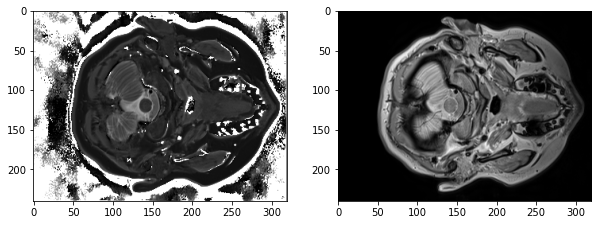

In [6]:
# Show the images t1 and pd
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(t1[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(pd[:,:,0], cmap='gray')
plt.show()


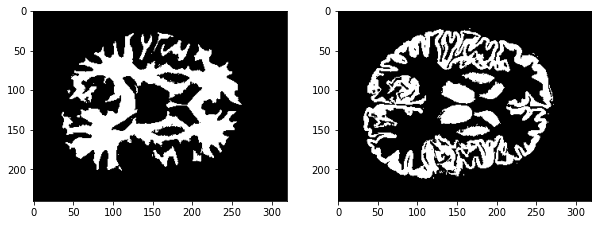

(240, 320, 60)
(240, 320, 60)
(240, 320, 60)


In [7]:
# Read the wm and gm masks 
wm, o3, s3, d3 = read_img_ants('/fileserver/fastscratch/prabh/projects/qt1/psirt1map/kristina_data/qT1Analysis_ForDifferentPulseSeq/psir_CRL/common-processed/modules/Parcellation/NVM/ParcellationNVM_WM.nii.gz')
gm, o4, s4, d4 = read_img_ants('/fileserver/fastscratch/prabh/projects/qt1/psirt1map/kristina_data/qT1Analysis_ForDifferentPulseSeq/psir_CRL/common-processed/modules/Parcellation/NVM/ParcellationNVM_GM.nii.gz')

# resample the matrix size of these masks to t1 and pd
input_image = ants.image_read('/fileserver/fastscratch/prabh/projects/qt1/psirt1map/kristina_data/qT1Analysis_ForDifferentPulseSeq/psir_CRL/common-processed/modules/Parcellation/NVM/ParcellationNVM_WM.nii.gz')
input_image2 = ants.image_read('/fileserver/fastscratch/prabh/projects/qt1/psirt1map/kristina_data/qT1Analysis_ForDifferentPulseSeq/psir_CRL/common-processed/modules/Parcellation/NVM/ParcellationNVM_GM.nii.gz')
target_image = ants.image_read('recons/tm.nrrd')
wm = ants.resample_image_to_target(input_image, target_image, interp_type=1)
gm = ants.resample_image_to_target(input_image2, target_image, interp_type=1)

# Get the numpy arrays of the masks
wm = wm.numpy()
gm = gm.numpy()

# Show the masks
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(wm[:,:,30], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gm[:,:,30], cmap='gray')
plt.show()

# print the shapes of t1 and wm and gm
print(t1.shape)
print(wm.shape)
print(gm.shape)


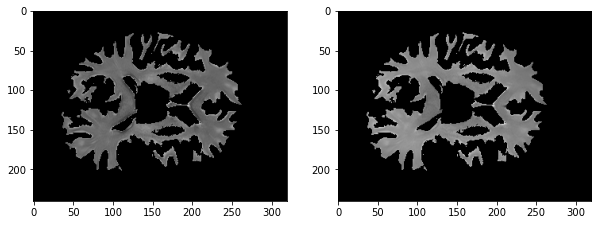

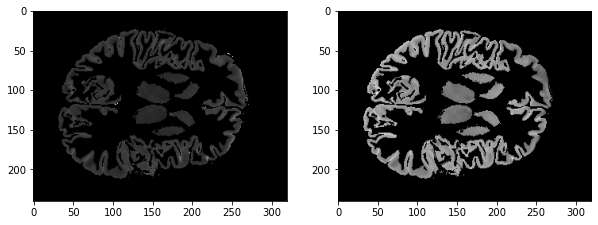

[0. 1.]
[0. 1.]


In [8]:
# SHow the masked t1 and pd
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(t1[:,:,30]*wm[:,:,30], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(pd[:,:,30]*wm[:,:,30], cmap='gray')
plt.show()

# Show the masked images for gm
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(t1[:,:,30]*gm[:,:,30], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(pd[:,:,30]*gm[:,:,30], cmap='gray')
plt.show()


# print unique values of gm and wm
print(np.unique(gm))
print(np.unique(wm))


In [9]:
y= (1* (1-(1-np.cos(2))*np.exp(-0/t1)))
y

array([[[-0.41614687, -0.41614687, -0.41614687, ..., -0.41614687,
         -0.41614687, -0.41614687],
        [-0.41614687, -0.41614687, -0.41614687, ..., -0.41614687,
         -0.41614687, -0.41614687],
        [-0.41614687, -0.41614687, -0.41614687, ..., -0.41614687,
         -0.41614687, -0.41614687],
        ...,
        [-0.41614687, -0.41614687, -0.41614687, ..., -0.41614687,
         -0.41614687, -0.41614687],
        [-0.41614687, -0.41614687, -0.41614687, ..., -0.41614687,
         -0.41614687, -0.41614687],
        [-0.41614687, -0.41614687, -0.41614687, ..., -0.41614687,
         -0.41614687, -0.41614687]],

       [[-0.41614687, -0.41614687, -0.41614687, ..., -0.41614687,
         -0.41614687, -0.41614687],
        [-0.41614687, -0.41614687, -0.41614687, ..., -0.41614687,
         -0.41614687, -0.41614687],
        [-0.41614687, -0.41614687, -0.41614687, ..., -0.41614687,
         -0.41614687, -0.41614687],
        ...,
        [-0.41614687, -0.41614687, -0.41614687, ..., -

In [10]:

fa = np.array(float(158) / 180. * np.pi )
print('This is for Flip Angle (radians) = ',fa)
y_gm_mean = []
y_wm_mean = []
tis=[]
for ti in range(0,3000,5):
    y= (pd* (1-(1-np.cos(fa))*np.exp(-ti/t1))) # INVERSION RECOVERY SEQUENCE - SIGNAL MODEL
    # Get masked y for gm and wm
    y_gm = y*gm
    y_wm = y*wm
    # Get the mean values for y_gm and y_wm for each TI
    y_gm_mean.append( np.mean(y[y_gm!=0]))
    y_wm_mean.append(np.mean(y[y_wm!=0]))
    tis.append(ti)
    # write_img_ants('edge/y_'+str(ti)+'.nrrd', y, o1, s1, d1)



This is for Flip Angle (radians) =  2.7576202181510405


In [11]:
print(len(tis))

600


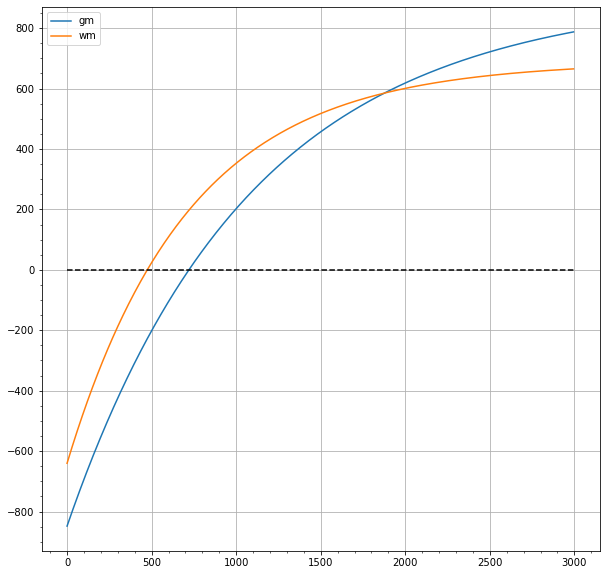

In [12]:
# plot the y_gm and y_wm versus tis
plt.figure(figsize=(10,10))
plt.plot(tis, y_gm_mean, label='gm')
plt.plot(tis, y_wm_mean, label='wm')
plt.legend()
# Also show the x-zis passing through origin
plt.plot([0,3000],[0,0], 'k--')
# show the grid
plt.grid()
# show the fine grid every 10 units
plt.minorticks_on()
plt.show()


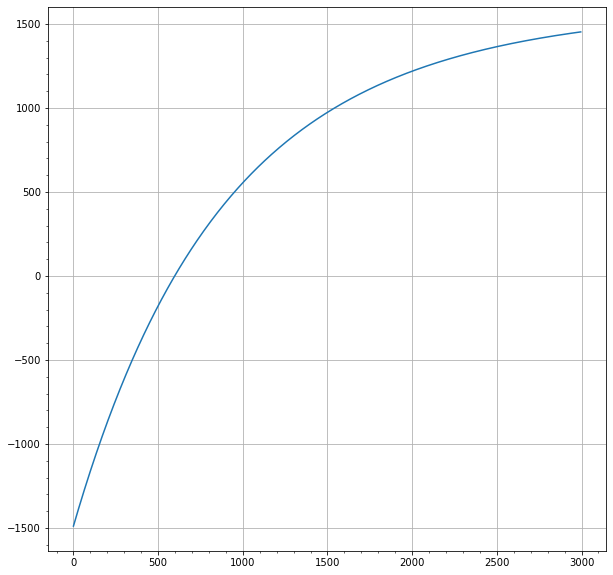

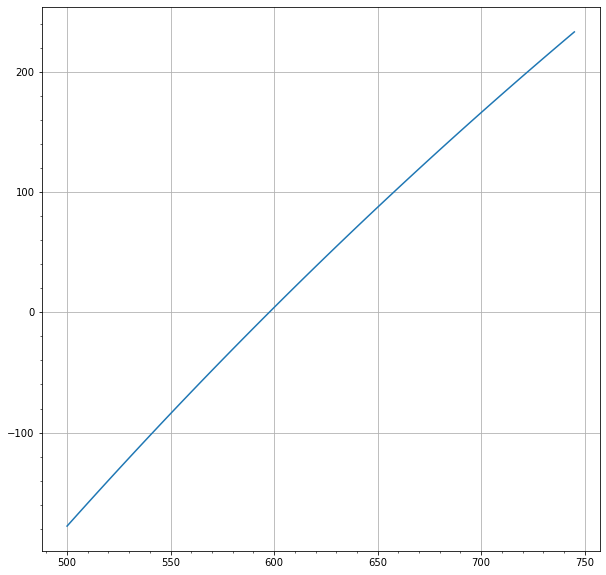

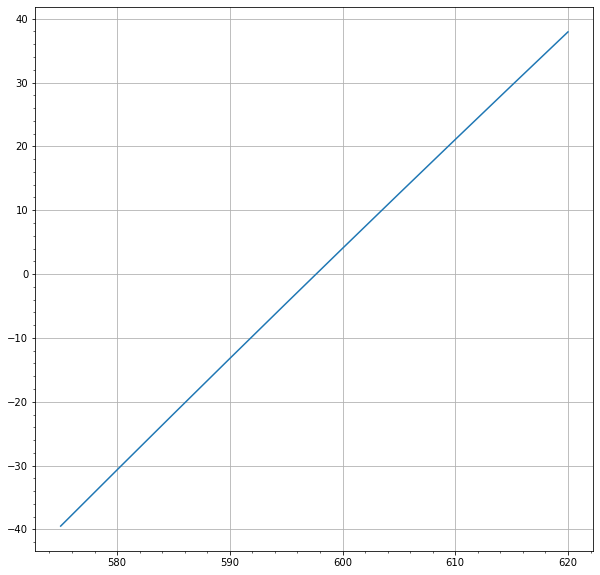

[-128.37325  -123.67215  -118.993    -114.33577  -109.70024  -105.086555
 -100.49411   -95.92338   -91.37368   -86.8454  ]
[ 88.90312   93.002144  97.07256  101.11456  105.12836  109.11413
 113.07215  117.00253  120.90555  124.78132 ]


In [39]:
plt.figure(figsize=(10,10))
plt.plot(tis,np.array(y_gm_mean)+np.array(y_wm_mean))
plt.grid()
# show the fine grid every 10 units
plt.minorticks_on()
plt.show()



plt.figure(figsize=(10,10))
plt.plot(tis[100:150],np.array(y_gm_mean[100:150])+np.array(y_wm_mean[100:150]))
plt.grid()
# show the fine grid every 10 units
plt.minorticks_on()
plt.show()


plt.figure(figsize=(10,10))
plt.plot(tis[115:125],np.array(y_gm_mean[115:125])+np.array(y_wm_mean[115:125]))
plt.grid()
# show the fine grid every 10 units
plt.minorticks_on()
plt.show()


print(np.array(y_gm_mean[115:125]))
print(np.array(y_wm_mean[115:125]))

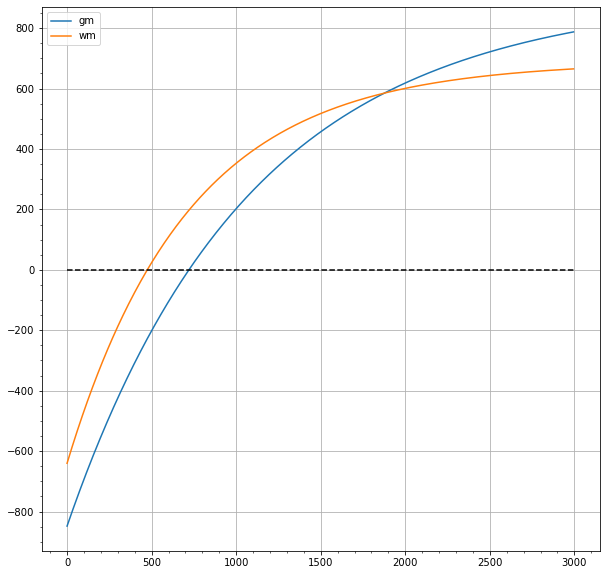

Zero crossing point is at 120
120 -105.086555 109.11413 600


In [254]:
# Define a function that computes y_gm and y_wm and return the zero crossing point of y_gm and y_wm

def get_zero_crossing_point(fa,t1,pd,paths):
    y_gm_mean = []
    y_wm_mean = []
    tis=[]
    for ti in range(0,3000,5):
        y= (pd* (1-(1-np.cos(fa))*np.exp(-ti/t1))) # INVERSION RECOVERY SEQUENCE - SIGNAL MODEL
        # Get masked y for gm and wm
        y_gm = y*gm
        y_wm = y*wm
        # Get the mean values for y_gm and y_wm for each TI
        y_gm_mean.append( np.mean(y[y_gm!=0]))
        y_wm_mean.append(np.mean(y[y_wm!=0]))
        tis.append(ti)
        #write_img_ants(paths+'y_'+str(ti)+'.nrrd', y, o1, s1, d1)

    # plot the y_gm and y_wm versus tis
    plt.figure(figsize=(10,10))
    plt.plot(tis, y_gm_mean, label='gm')
    plt.plot(tis, y_wm_mean, label='wm')
    plt.legend()
    # Also show the x-zis passing through origin
    plt.plot([0,3000],[0,0], 'k--')
    # show the grid
    plt.grid()
    # show the fine grid every 10 units
    plt.minorticks_on()
    plt.show()
    
    diff=np.array(y_gm_mean)+np.array(y_wm_mean)
    index = np.where(np.abs(diff)==np.min(np.abs(diff)))[0][0]
    print('Zero crossing point is at',index)
    print(index,y_gm_mean[index],y_wm_mean[index],tis[index])
    
    w=np.zeros(y.shape)
    for i in range( index*5-20,index*5+20, 5):
        y= (  (pd* (1-(1-np.cos(fa))*np.exp(-(i)/t1)))) # *((wm +gm)!=0)
        write_img_ants(paths+'/ti_'+str(i)+'.nrrd', (y), o1, s1, d1)
        z=1.0*(np.abs(y)<30)
        w = w + z
        write_img_ants(paths+'/ti_'+str(i)+'seg.nrrd', (z), o1, s1, d1)
    
    w=1.0*(w!=0)
    ids= 1.0*((wm+gm)!=0) * (w)
    write_img_ants(paths+'/combinedZerosSeg.nrrd', (ids), o1, s1, d1)

    y= (  (pd* (1-(1-np.cos(fa))*np.exp(-(tis[index])/t1)))) # *((wm +gm)!=0)
    write_img_ants(paths+'/ti_'+str(i)+'zerocrossing.nrrd', (y), o1, s1, d1)
    z=1.0*(np.abs(y)<30) * (wm + gm)
    write_img_ants(paths+'/ti_'+str(i)+'zerocrossing_seg.nrrd', (z), o1, s1, d1)

    return ids,z, tis[index]

# Call the function
ids,zerocrossingids,ti = get_zero_crossing_point(fa,t1,pd,'edge')


In [259]:
from scipy.stats import mode
write_img_ants('edge/Forinput.nrrd', ids, o1, s1, d1)
# fit a gmm model onto it
from sklearn.mixture import GaussianMixture
# define a funtion to save the nrrd file for given cluster
def save_t1ForClsuter(ids,t1):
    zt1=t1[ids!=0]
    print(zt1.shape,t1.shape)
    hist, bin_edges = np.histogram(zt1, bins=[100,700,1300,3500])
    print(hist)
    print(bin_edges)
    
    # Assign labels to each value based on its bin
    bin_labels = 1.0*np.digitize(zt1.reshape(-1,1), bin_edges)
    print('HIIIIIIIIIIIIIIIIIII',(bin_labels))
    la=0.0*t1
    bin_labels=bin_labels.reshape(-1)
    print(np.sum(ids!=0),np.shape(la),np.shape(bin_labels[0]))
    la[ids!=0]=bin_labels
    write_img_ants('edge/T1ThresholdBasedMAskEDGES.nrrd', la, o1, s1, d1)

    # gmm = GaussianMixture(n_components=3).fit(zt1.reshape(-1,1))
    # labels = gmm.predict(zt1.reshape(-1,1))
    # # remove the label with maximum number of elements
    # print(np.unique(labels))
    # print(mode(labels))
    # fulllabels=0.0*t1
    # fulllabels[ids!=0]=labels
    # print(np.unique(fulllabels))

    # # print centroid and standard deviation of the three clusters
    # print(gmm.means_,gmm.covariances_)
    # write_img_ants('edge/T1ThresholdBasedMAskALL.nrrd', fulllabels, o1, s1, d1)
    means=np.zeros((4,1))
    stds=np.zeros((4,1))
    fulllabels=la
    for i in range(0,4):
        print(np.sum(fulllabels==i))
        # plot the histogram of t1 values in each cluster
        if np.any(bin_labels==i):
            print('HEREEEEEEEEEEEEEEEEEEEE',bin_labels)
            plt.figure(figsize=(10,10))
            print(zt1[bin_labels==i])
            plt.hist(zt1[bin_labels==i].reshape(-1,1), bins=100)
            plt.show()
            if np.sum(fulllabels==i)<4000000:
                roi=1.0*(fulllabels==i)
                t1t=t1*roi
                print(np.min(t1t[t1t!=0]),np.max(t1t[t1t!=0]))
                within = (t1 >=np.min(t1t[t1t!=0])) & (t1 <=np.max(t1t[t1t!=0])) 
                thresholdedt1=0.0*t1
                thresholdedt1[within!=0]=1.0
                # write nrrd image
                write_img_ants('edge/T1ThresholdBasedMAsk'+str(i)+'.nrrd', thresholdedt1, o1, s1, d1)
                means[i]=np.mean(zt1[bin_labels==i])
                stds[i]=np.std(zt1[bin_labels==i])
    return means, stds


# call the function
means,stds =save_t1ForClsuter(ids,t1)

print(means,stds)

# choose the mean which lies inside [700, 1300]
chosenmean=means[(means>700) & (means<1300)]
chosenstd=stds[(means>700) & (means<1300)]
t1min= chosenmean-2*chosenstd
t1max= chosenmean+2*chosenstd
print(t1min,t1max)
ids2=0.0*ids
ids2[(t1>t1min) & (t1<t1max)]=1

write_img_ants('edge/t1mapBasedCuttOFF.nrrd', (ids2), o1, s1, d1)

# clear output of cell
from IPython.display import clear_output
clear_output()

In [260]:
ids2=0.0*t1
ids2[(t1>t1min) & (t1<t1max)]=1

write_img_ants('edge/t1mapBasedCuttOFFOnT1image.nrrd', (ids2), o1, s1, d1)

# clear output of cell
from IPython.display import clear_output
clear_output()

In [ ]:
def get_t1_at_zero_crossing(ids,t1):
    zt1=0.0*t1
    zt1=t1[ids!=0]
    # Show the histogram of zt1
    plt.figure(figsize=(10,10))
    plt.hist(zt1.reshape(-1,1), bins=100)
    plt.show()

    return zt1

# Call the function
zt1 = get_t1_at_zero_crossing(ids,t1)

# compute the hist of zt1 with specified center of bins and width
# Define the bin centers and bin width
bin_centers = np.array([100, 900, 1300, 5000])


hist, aa = np.histogram(zt1, bins=bin_centers)

# and operate on the zt1 non zero values and ids
zt1=zt1[zt1!=0]
# Find the zero crossing of the curve
diff=np.array(y_gm_mean)+np.array(y_wm_mean)
print(diff.shape)
index = np.where(np.abs(diff)==np.min(np.abs(diff)))[0][0]
print(index)
print(index,y_gm_mean[index],y_wm_mean[index],tis[index])

In [40]:
# Save TI image at ti=375
y= (pd* (1-(1-np.cos(fa))*np.exp(-(120*5)/t1)))
write_img_ants('edge/ti_ZeroCrossing.nrrd', y, o1, s1, d1)
# Here I shall expect to see similar values for gm and wm, no contrast between GM and WM

In [157]:
# Save farther images from zero crossing
w=np.zeros(y.shape)
print(w.shape)
for i in range( 120*5-20,120*5+20, 5):
    y= (  (pd* (1-(1-np.cos(fa))*np.exp(-(i)/t1)))) # *((wm +gm)!=0)
    write_img_ants('edge/ti_'+str(i)+'.nrrd', (y), o1, s1, d1)
    z=1.0*(np.abs(y)<30)
    w = w + z
    write_img_ants('edge/ti_'+str(i)+'seg.nrrd', (z), o1, s1, d1)
    
w=1.0*(w!=0)
ids= 1.0*((wm+gm)!=0) * (w)
write_img_ants('edge/combinedZerosSeg.nrrd', (ids), o1, s1, d1)

(240, 320, 60)


In [141]:
# load teh t1 map
t1 = ants.image_read('recons/tm.nrrd')
t1 = t1.numpy()
print(t1.shape)


(240, 320, 60)


(240, 320, 60)
[ 36   6   4   3   3   5   3   4   1   1   1   0   1   1   0   1   0   0
   0   0 761  33  19  12   3   4   7   0   3   1   0   0   0   0   1   1
   0   1   0   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 134]
[1.4032000e-04 5.0000137e+01 1.0000014e+02 1.5000014e+02 2.0000014e+02
 2.5000014e+02 3.0000012e+02 3.5000012e+02 4.0000012e+02 4.5000012e+02
 5.0000012e+02 5.5000012e+02 6.0000012e+02 6.5000012e+02 7.0000012e+02
 7.5000012e+02 8.0000012e+02 8.5000012e+02 9.0000012e+02 9.5000012e+02
 1.0000001e+03 1.0500001e+03 1.1000001e+03 1.1500001e+03 1.2000001e+03
 1.2500001e+03 1.3000001e+03 1.3500001e+03 1.4000001e+03 1.4500001e+03
 1.5000001e+03 1.5500001e+03 1.6000001e+03 1.6500001e+03 1.7000001e+03
 1.7500001e+03 1.8000001e+03 1.8500001e+03 1.9000001e+03 1.9500001e+03
 2.0000001

Text(0.5, 1.0, 'Histogram of T1 values in non-null regions')

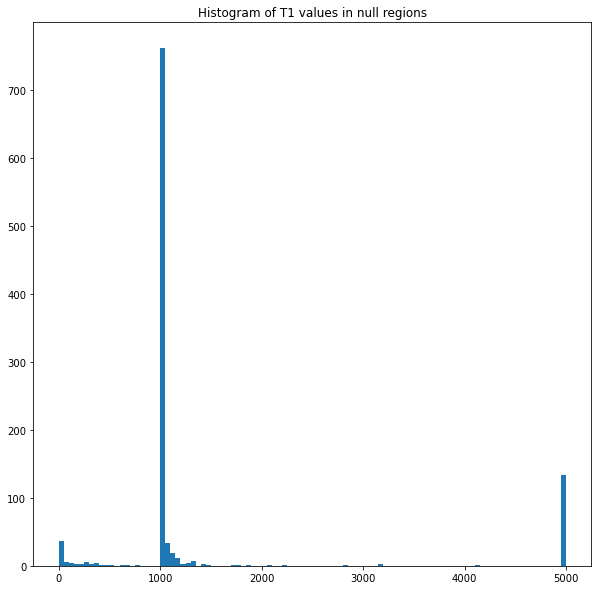

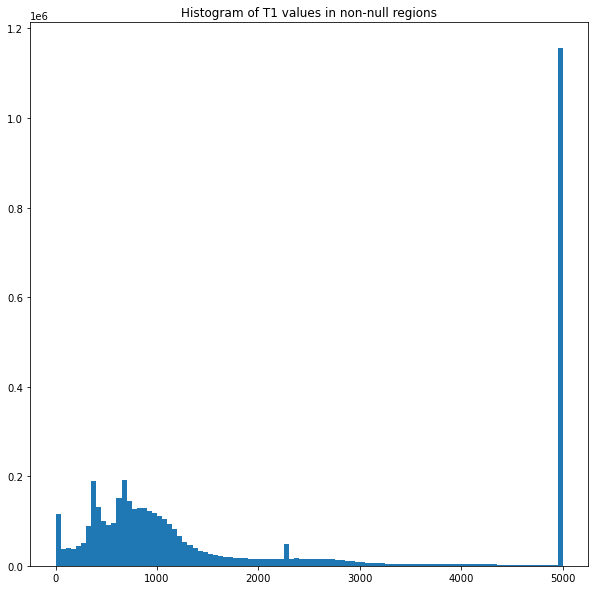

In [142]:
print(w.shape)
# plot the distribution of t1 values in w!=0


(191598,) (240, 320, 60)
[    87 191283     35]
[ 100  700 1300 3500]
HIIIIIIIIIIIIIIIIIII [[3.]
 [3.]
 [2.]
 ...
 [2.]
 [2.]
 [2.]]
191598 (240, 320, 60) ()
4416444
HEREEEEEEEEEEEEEEEEEEEE [3. 3. 2. ... 2. 2. 2.]
[5.72860718e-01 6.38257265e-01 4.69073914e-02 2.01982331e+00
 4.19337893e+00 1.96546125e+00 4.56043869e-01 2.37633848e+00
 4.02321279e-01 3.06229076e+01 1.61439371e+00 2.11518869e-01
 2.00632739e+00 9.89020094e-02 1.40320000e-04 8.79096270e-01
 1.15906432e-01 5.90422897e+01 3.86559892e+00 1.97779223e-01
 4.47592850e+01 1.35683119e+00 1.21308625e-01 4.57685739e-01
 2.24908233e+00 7.86520600e-01 6.01018732e-03 8.31172049e-01
 3.91112900e+01 3.65220994e-01 1.74066138e+00 5.17504044e+01
 5.42539358e-01 2.64809072e-01 3.90013084e+01 7.20601425e+01
 9.51351624e+01 1.51939654e+00 2.91595340e+00 1.46042719e-01
 8.03516388e+01 5.72292404e+01]


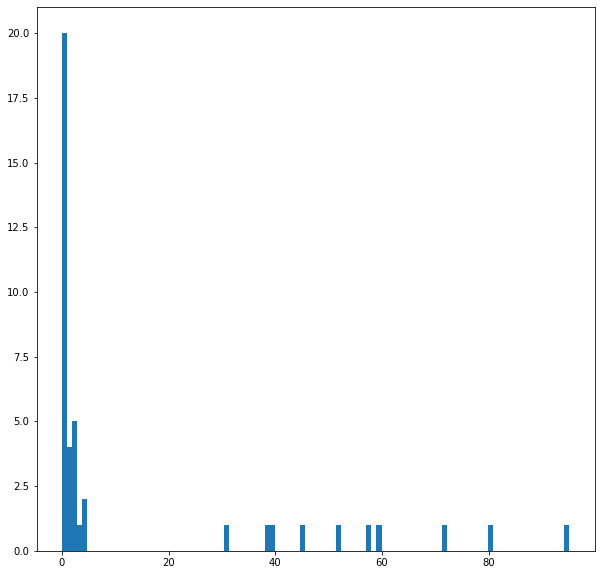

87
HEREEEEEEEEEEEEEEEEEEEE [3. 3. 2. ... 2. 2. 2.]
[277.76767  605.6987   146.0053   641.2458   568.5764   504.67712
 204.1755   155.75098  375.37802  348.58664  578.45337  117.492905
 654.7954   647.6453   416.92303  617.66626  544.50037  653.24866
 569.0022   523.6869   656.1135   605.2594   582.18243  364.4578
 624.8673   530.26465  262.5561   659.87244  625.5191   528.1356
 181.0422   698.1976   267.18527  669.6421   167.41206  282.73273
 384.6132   370.48572  141.42102  606.23975  353.47852  375.6701
 414.0913   305.74927  205.98392  341.30286  369.88443  496.74927
 685.5067   452.99945  414.55182  567.1147   370.2632   374.3256
 584.33984  497.96872  165.00955  678.5057   464.96173  632.31793
 646.32623  666.1848   385.12436  225.48143  647.93854  329.25467
 515.84454  541.96655  304.90118  205.65086  209.1874   582.7677
 273.933    635.0462   306.06702  623.0954   283.10214  569.2772
 607.4284   204.93349  673.6522   599.1262   663.6619   263.96954
 145.96237  654.58563  349.852

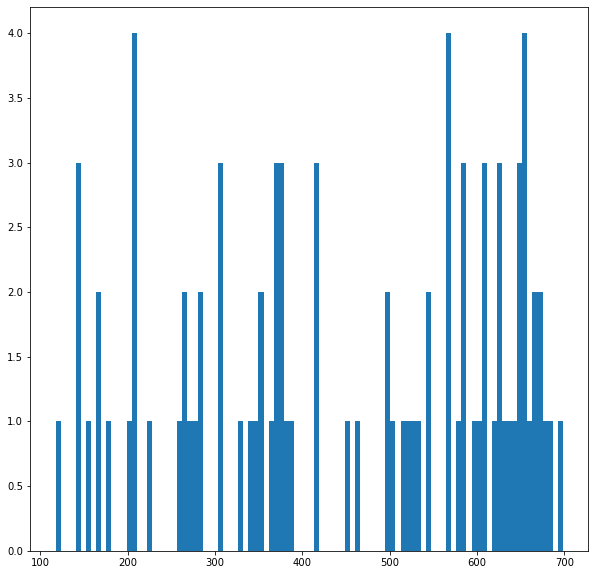

117.49290466308594 698.1975708007812
191283
HEREEEEEEEEEEEEEEEEEEEE [3. 3. 2. ... 2. 2. 2.]
[958.3655  952.1112  958.60565 ... 959.93744 983.05414 949.6128 ]


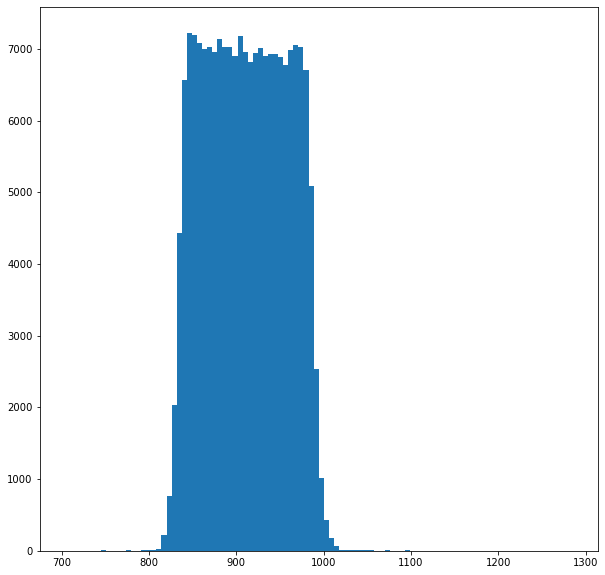

704.0257568359375 1284.57177734375
35
HEREEEEEEEEEEEEEEEEEEEE [3. 3. 2. ... 2. 2. 2.]
[1719.0388 2396.9883 2680.3008 3172.7532 1328.0251 3159.4385 1677.9967
 2846.1306 1322.4857 3180.2058 1788.9922 2435.435  1307.9463 2216.4417
 1308.5366 3107.0398 1701.4622 2100.7568 1635.734  2348.0562 3288.3657
 2055.6475 1771.0681 2716.6245 1879.22   1734.2554 1331.1742 1433.2233
 1341.0995 1567.3893 1480.5168 1408.1097 1416.8585 1324.1136 1700.4254]


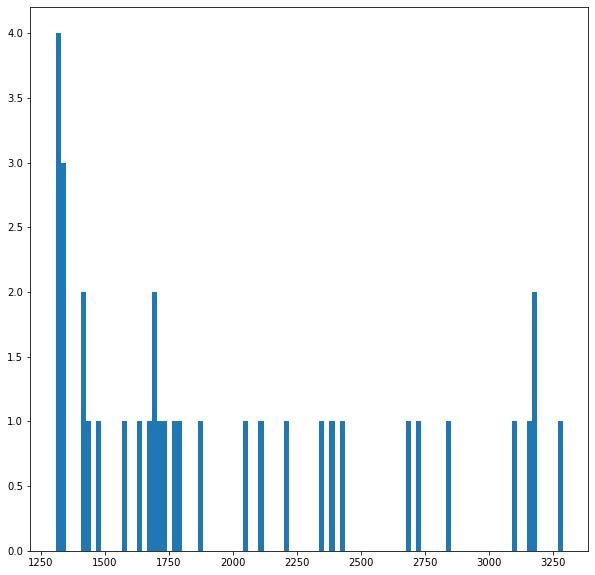

1307.9462890625 3288.36572265625
[[   0.        ]
 [ 450.8571167 ]
 [ 910.77905273]
 [1996.62438965]] [[  0.        ]
 [174.76422119]
 [ 46.62266541]
 [645.18432617]]


[817.53372192] [1004.02438354]


In [ ]:
1.92*0.652


1.25184

In [ ]:
t1

array([[[2272.7124 , 2272.7124 , 2272.7124 , ..., 2272.7124 ,
         2272.7124 , 2272.7124 ],
        [2272.7124 , 2272.7124 , 2272.7124 , ..., 2272.7124 ,
         2272.7124 , 2272.7124 ],
        [2272.7124 , 2272.7124 , 2272.7124 , ..., 2272.7124 ,
         2272.7124 , 2272.7124 ],
        ...,
        [2272.7124 , 2272.7124 , 2272.7124 , ..., 2272.7124 ,
         2272.7124 , 2272.7124 ],
        [2272.7124 , 2272.7124 , 2272.7124 , ..., 2272.7124 ,
         2272.7124 , 2272.7124 ],
        [2272.7124 , 2272.7124 , 2272.7124 , ..., 2272.7124 ,
         2272.7124 , 2272.7124 ]],

       [[5000.     , 5000.     , 5000.     , ..., 5000.     ,
         3750.9033 , 5000.     ],
        [5000.     , 5000.     , 5000.     , ..., 5000.     ,
         3750.9033 , 5000.     ],
        [5000.     , 5000.     , 5000.     , ..., 5000.     ,
         3750.9033 , 5000.     ],
        ...,
        [5000.     , 5000.     , 2407.1814 , ..., 5000.     ,
         5000.     , 5000.     ],
        [500

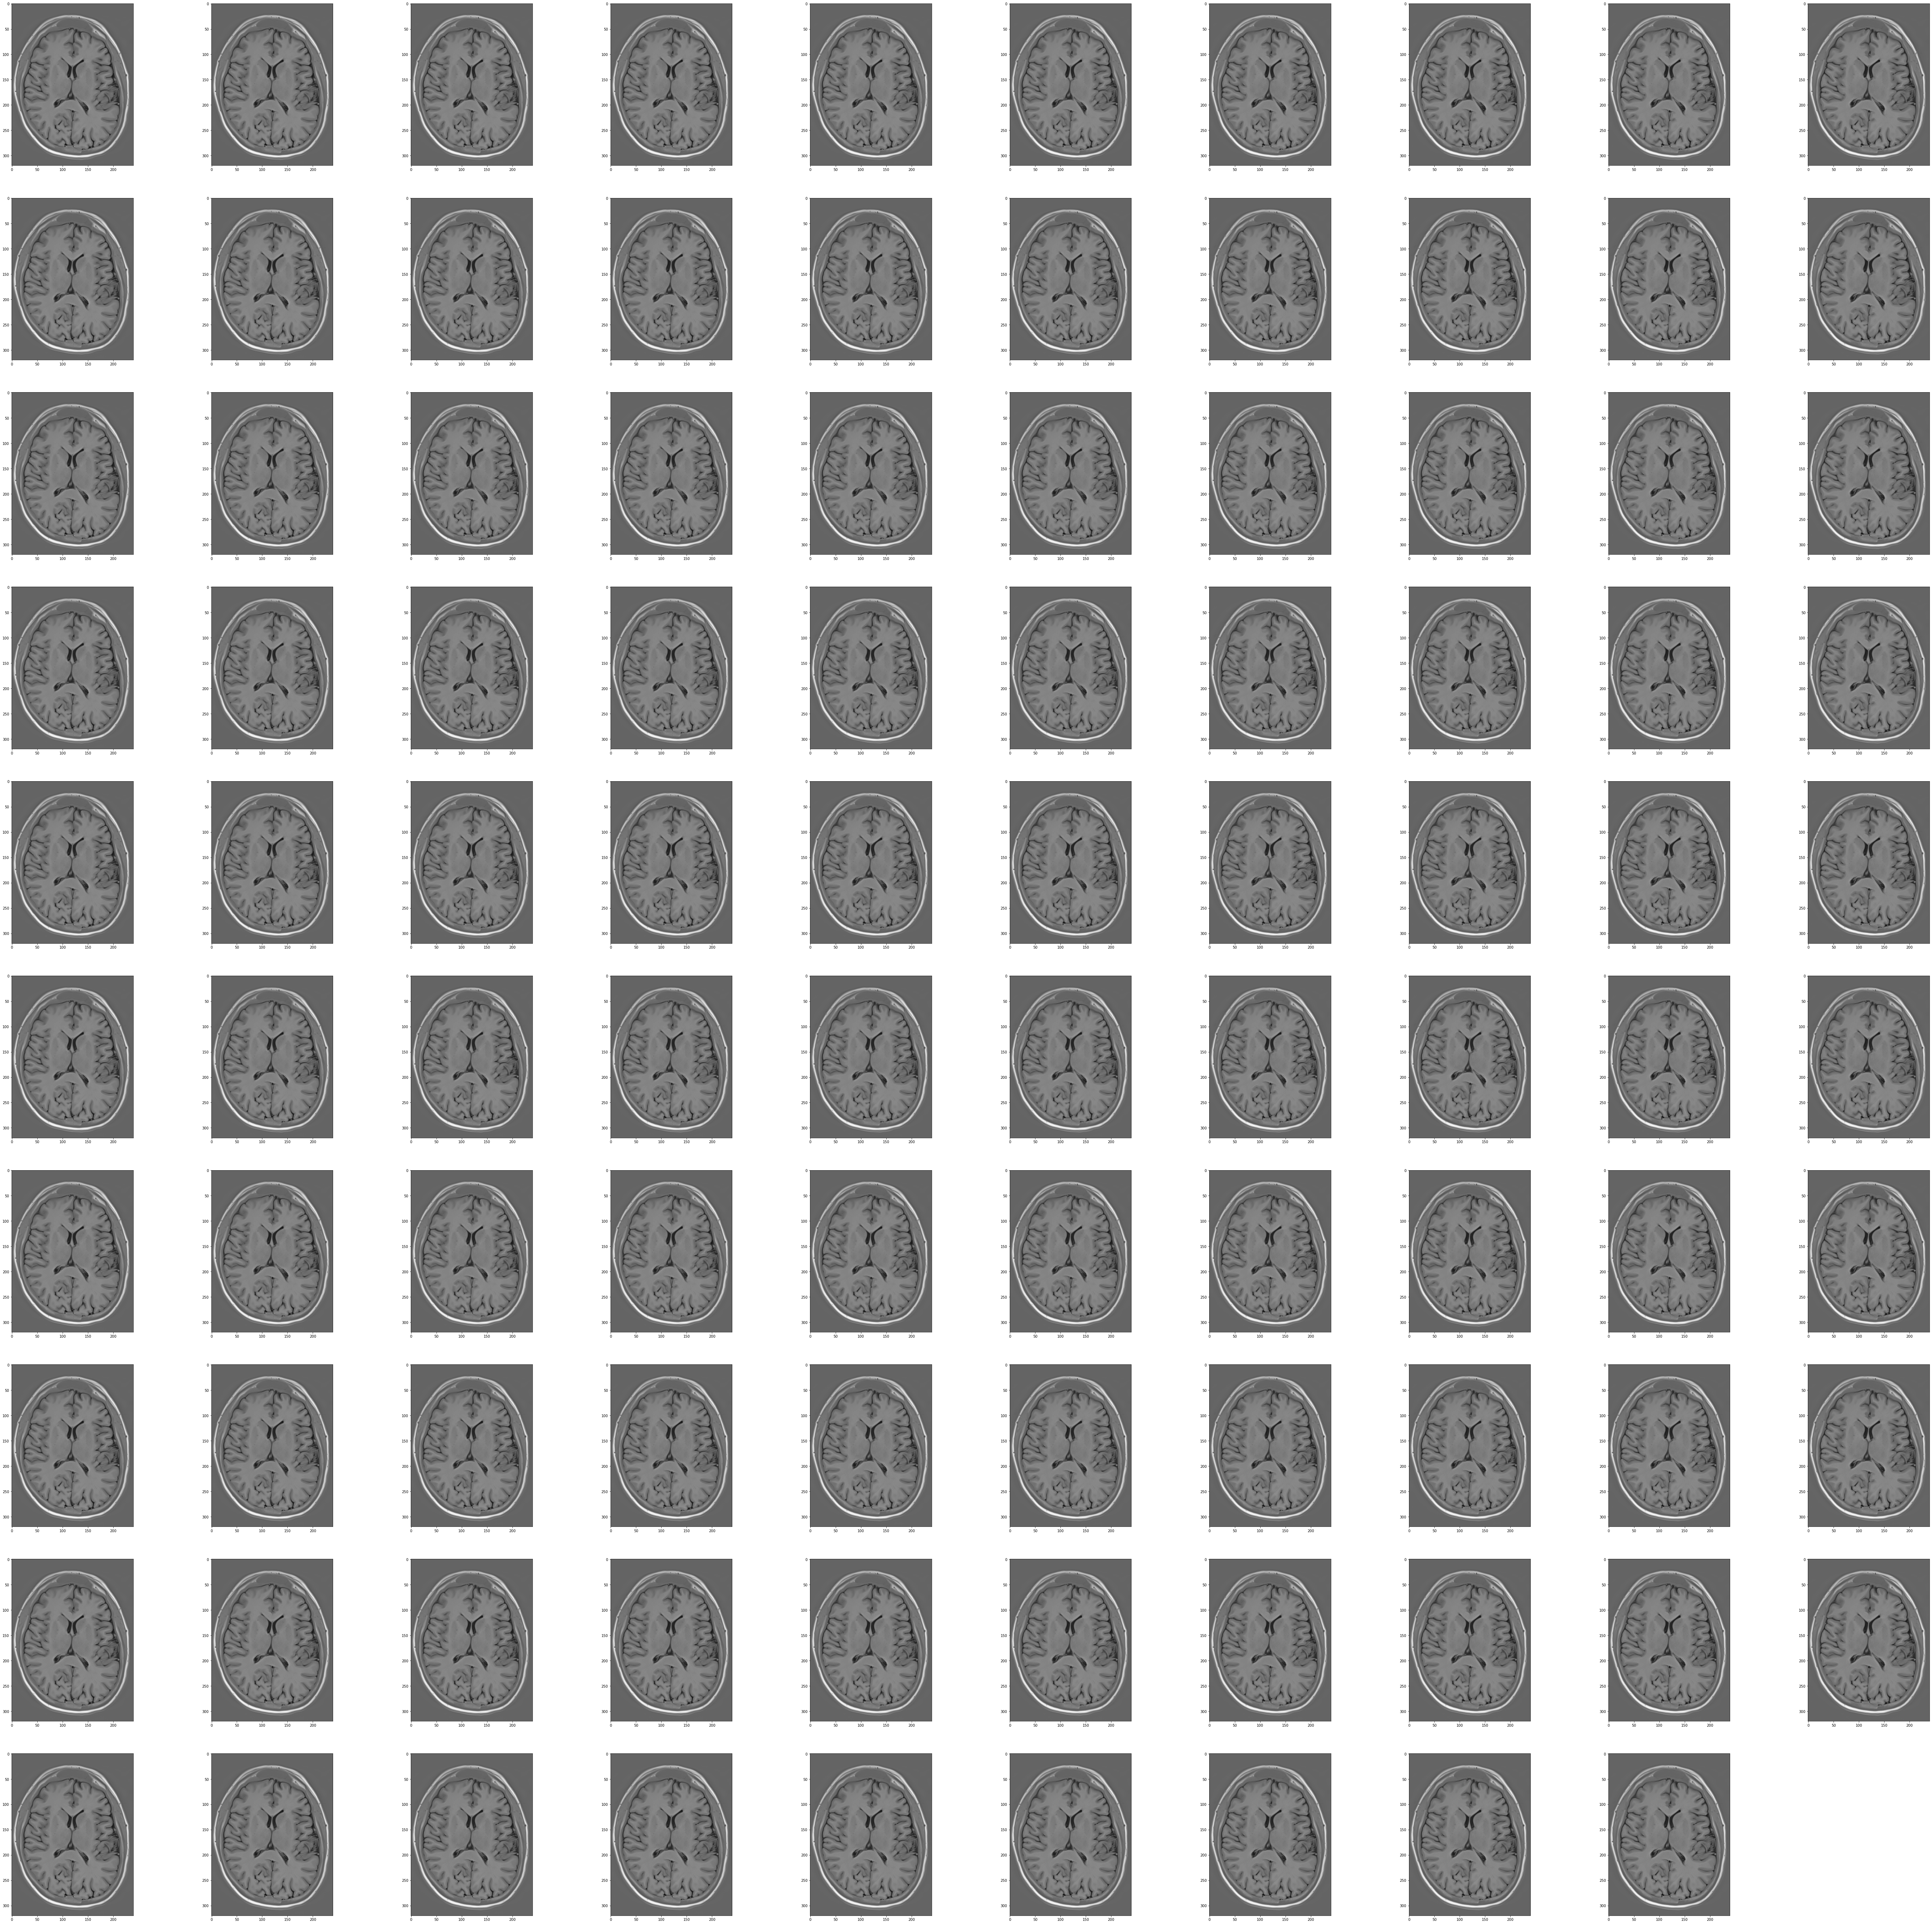

<Figure size 432x288 with 0 Axes>

In [ ]:
# show the images in subplt
plt.figure(figsize=(100,100))
for i in range(1,100):
    plt.subplot(10,10,i)
    y= (pd* (1-(1-np.cos(fa))*np.exp(-ti/t1))) 
    y=np.transpose(y[:,:,30])
    # vertical flip y
    y=np.flipud(y)
    plt.imshow(y,cmap='gray')

plt.show()
plt.savefig('edge/tis.png')